    Задача:
- Запустите A/A-тест
- Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000).
- Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента.
- Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

In [2]:
# Импортируем нужные библиотеки
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [4]:
# Загружаем датафрейм
df = pd.read_csv('hw_aa.csv', sep=';').drop(columns='Unnamed: 0')

In [5]:
# Посмотрим на датафрейм
df.head()

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [80]:
df.dtypes

uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [78]:
df.isnull().sum()

uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

Разобьем наши данные на 2 группы experimentVariant == 1 и experimentVariant == 0 и запустим А/А тест

  0%|          | 0/1000 [00:00<?, ?it/s]

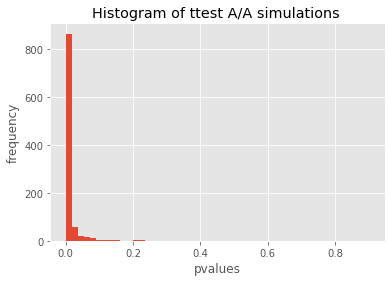

0.939

In [55]:
simulations = 1000
n_s = 1000
res = []



# Запуск A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 0].purchase.sample(n_s, replace = False).values
    s2 = df[df.experimentVariant == 1].purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

FPR > альфа. Сплит работает некорректно.

Разберемся в чем дело.

Сгруппируем данные по версии мобильного приложения и найдем конверсию(коэф.) покупок


In [6]:
# Найдмем CR для experimentVariant == 0
df[df.experimentVariant == 0].groupby('version', as_index=False).purchase.mean().rename(columns={'purchase' : 'CR'})

,version,CR
0,v2.8.0,0.000993
1,v2.9.0,0.074658
2,v3.7.4.0,0.059943
3,v3.8.0.0,0.057604


In [7]:
# Найдмем CR для experimentVariant == 1
df[df.experimentVariant == 1].groupby('version', as_index=False).purchase.mean().rename(columns={'purchase' : 'CR'})

,version,CR
0,v2.8.0,0.045606
1,v2.9.0,0.071304
2,v3.7.4.0,0.063018
3,v3.8.0.0,0.062848


Видно, что в наших группах конверсии у мобильной версии v2.8.0 различаются.

___


Проведем А/А тесты для каждой версии мобильного приложения.


In [8]:
# Записываем массив с уникальными версия в переменную 'versions'
versions = df.version.unique()

  0%|          | 0/1000 [00:00<?, ?it/s]

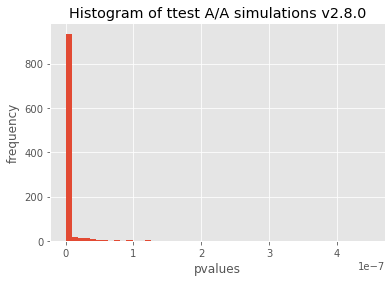

FPR = 1.0


  0%|          | 0/1000 [00:00<?, ?it/s]

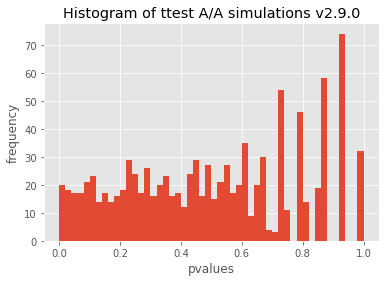

FPR = 0.046


  0%|          | 0/1000 [00:00<?, ?it/s]

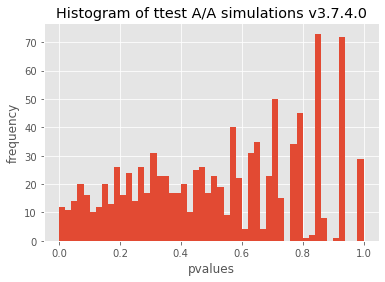

FPR = 0.032


  0%|          | 0/1000 [00:00<?, ?it/s]

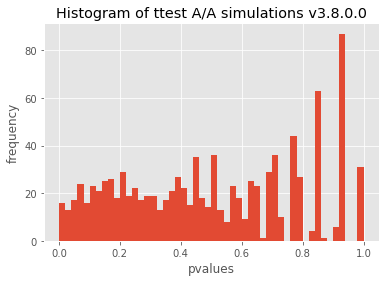

FPR = 0.039


In [83]:


for x in versions:
    simulations = 1000
    n_s = 1000
    res = []

    # Запуск симуляций A/A теста
    for i in tqdm(range(simulations)):
        s1 = df[(df.experimentVariant == 0) & (df.version == x)].purchase.sample(n_s, replace = False).values
        s2 = df[(df.experimentVariant == 1) & (df.version == x)].purchase.sample(n_s, replace = False).values
    
        res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue
    
    plt.hist(res, bins = 50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title(f"Histogram of ttest A/A simulations {x}")
    plt.show()

    # Проверяем, что количество ложноположительных случаев не превышает альфа
    print('FPR =',sum(np.array(res) <0.05) / simulations)

Как и было замечено ранее для версии v2.8.0 :
- Значение p value очень низкое (~ 0,00001)
- FPR = 1
Сплит составлен некорректно.

По остальным данным FPR менее альфа
___

Исключим данные с мобильной версией v2.8.0' и запустим тест еще раз

  0%|          | 0/1000 [00:00<?, ?it/s]

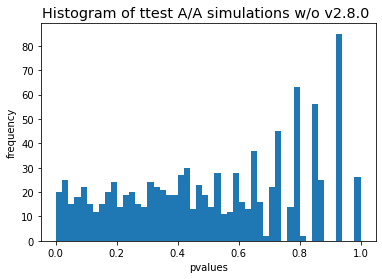

FPR = 0.048


In [9]:

simulations = 1000
n_s = 1000
res = []



# Запуск  A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 0) & (df.version != 'v2.8.0')].purchase.sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 1) & (df.version != 'v2.8.0')].purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations w/o v2.8.0 ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
print('FPR =',sum(np.array(res) <0.05) / simulations)

FPR меньше альфа, можем сделать вывод, что поломка сплит системы действительно основана на версии v2.8.0.
Стоит обратить внимание на работу сплит системы. Возможно, рандомизатор работает некорректно.